## Workers Function
---

In [4]:
import sys
import pandas as pd
import numpy as np
import shortuuid as uid
from datetime import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

## Full Version 1.1

In [5]:
# ----------------------------------------- Crowdsourcing task optimization ----------------------------------------- 

# ### Tasks and Workers Dataframe Construction
def workers_algorithm(total_tasks = 100, total_workers = 40, p_hard_tasks = 0.2, p_good_workers = 0.8,
                      answers_key = ["liver", "blood", "lung", "brain", "heart"], 
                      p_train_tasks = 0.4, workers_per_task = 7):
    total_tasks =  total_tasks #int(input("Number of Total Tasks: "))  #100
    total_workers = total_workers #int(input("Number of Total Workers: "))  #40

    p_hard_tasks = float(p_hard_tasks) #float(input("Percentage of Hard Tasks (decimal): ")) # 0.2
    n_hard_tasks = int(round(p_hard_tasks*total_tasks,0))
    p_easy_tasks = 1-p_hard_tasks 
    n_easy_tasks = int(round(p_easy_tasks*total_tasks,0))
    print('Hard Tasks: {} \nEasy Tasks: {}'.format(n_hard_tasks, n_easy_tasks))

    #Workers variables
    p_good_workers = float(p_good_workers) #float(input("Percentage of Good Workers (decimal): ")) #0.8
    n_good_workers = int(round(p_good_workers*total_workers,0))
    p_poor_workers = 1-p_good_workers
    n_poor_workers = int(round(p_poor_workers*total_workers,0))
    print('Good Workers: {} \nPoor Workers: {}'.format(n_good_workers, n_poor_workers))

    # Workers simulation
    workers = [uid.ShortUUID().random(length=5) for i in range(total_workers)]
    poor_workers = [worker for worker in np.random.choice(workers, n_poor_workers, replace=False)]
    good_workers = [worker for worker in set(workers)-set(poor_workers)]

    # Creating the workers dataframe
    df_workers = pd.DataFrame()
    df_workers['worker_id'] = workers

    label_worker = []
    for i in range(total_workers):
        if workers[i] in good_workers:
            label_worker.append('good_worker')
        else:
            label_worker.append('poor_worker')

    df_workers['label_worker'] = label_worker

    # Tasks simulatiom
    tasks = ['task_'+uid.ShortUUID().random(length=3) for i in range(total_tasks)]
    easy_tasks = [task for task in np.random.choice(tasks, n_easy_tasks, replace=False)]
    hard_tasks = [task for task in set(tasks)-set(easy_tasks)]

    answers_key = ["liver", "blood", "lung", "brain", "heart"]
    #print('Tasks Answers: {}'.format(answers_key))
    real_answers = [answer for answer in np.random.choice(answers_key, total_tasks)]
    df_tasks = pd.DataFrame()
    df_tasks['task_id'] = tasks
    df_tasks['real_answers'] = real_answers

    label_task = []
    for i in range(total_tasks):
        if tasks[i] in hard_tasks:
            label_task.append('hard_task')
        else:
            label_task.append('easy_task')

    df_tasks['label_task'] = label_task


    # ----------------------------------------- Probability to Respond ----------------------------------------- 
    cut_tasks = 0.75
    cut_workers = 0.75

    probs_tasks = []
    for i in label_task:
        if i == 'easy_task':
            probs_tasks.append(np.random.choice((np.arange(cut_tasks, 1, 0.01)), 1)) #a random number form cut to 1
        elif i == 'hard_task':
            probs_tasks.append(np.random.choice((np.arange(0.5, cut_tasks, 0.01)), 1)) #a random number form chance to cut
        else: probs_tasks.append(1)

    probs_tasks = [item for prob in probs_tasks for item in prob]

    probs_workers = []
    for i in label_worker:
        if i == 'good_worker':
            probs_workers.append(np.random.choice((np.arange(cut_workers, 1, 0.01)), 1)) #a random number form cut to 1
        elif i == 'poor_worker':
            probs_workers.append(np.random.choice((np.arange(0.5, cut_workers, 0.01)), 1)) #a random number form chance to 1
        else: probs_workers.append(1)

    probs_workers = [item for prob in probs_workers for item in prob]

    df_workers['prob_worker'] = probs_workers
    df_tasks['prob_task'] = probs_tasks


    # ----------------------------------------- Stage 1 ----------------------------------------- 

    p_train_tasks = float(p_train_tasks) #float(input("Percentage of Tasks to Train (decimal): ")) #.4 #percentage
    #workers_per_task = 7 #more conditions

    tasks_to_train = int(p_train_tasks*total_tasks)
    print('Tasks to train: {}'.format(tasks_to_train))

    # Take randomly the number of tasks to train the workers
    training_tasks = np.random.choice(tasks, tasks_to_train, replace=False)

    list_tasks1 = [[training_tasks[i]]*workers_per_task for i in range(tasks_to_train)] #replicate the tasks to train 
    list_tasks1 = [item for sublist in list_tasks1 for item in sublist] #flat and clean list

    # Asign workers on every task (we're assuming the tasks are ordered)
    tasks_workers1 = [np.random.choice(workers, workers_per_task, replace=False) for task in training_tasks]
    tasks_workers1 = [worker for sublist in tasks_workers1 for worker in sublist] #flat and clean list

    temp_frame = pd.DataFrame()
    temp_frame['task_id'] = list_tasks1
    temp_frame['worker_id'] = tasks_workers1

    workers_agg = temp_frame.groupby('worker_id').agg('count')
    workers_agg.sort_values('task_id', ascending=False)
    num_workers_trained = len(workers_agg.reset_index())
    print('Workers Trained: {}'.format(num_workers_trained))

    # Merge the datasets stage 1
    temp_frame1 = pd.merge(temp_frame, df_tasks, on='task_id', how='left')
    df_tw1 = pd.merge(temp_frame1, df_workers, on='worker_id', how='left')

    #Probability to asnwer correct
    df_tw1['prob_answer'] = 1-(df_tw1['prob_worker']*(1-df_tw1['prob_task']))

    # We want to get where is the position of the real_answer column on the answer_key array
    positions = []
    for answer in df_tw1['real_answers']:
        for k in range(len(answers_key)):
            if answers_key[k] == answer:
                positions.append(k)

    # Assign a vector of probabilities depending on the position of the item on anser_key array
    list_vect_probs = []
    for p in df_tw1['prob_answer']:
        for i in positions:
            vec_probs = [(1-p)/(len(answers_key)-1)] * (len(answers_key)-1)
            vec_probs.insert(i,p) #insert place, value
        list_vect_probs.append(vec_probs)

    #"Predict" every answer
    worker_answers = []
    for vec in list_vect_probs:
        worker_answers.append(np.random.choice(answers_key, 1, p=vec))

    worker_answers = [item for answer in worker_answers for item in answer]
    df_tw1['worker_answers'] = worker_answers

    #We match the real answers with worker answers
    vec_matches = df_tw1['worker_answers'] == df_tw1['real_answers']
    predict_value =[1 if i == True else 0 for i in vec_matches]
    df_tw1['performance'] = predict_value

    # ----------------------------------------- Measuring Performance ----------------------------------------- 

    cutoff_task = 0.5 #More than 50% of consensus

    tasks_mean1 = df_tw1.groupby('task_id').mean().sort_values('performance', ascending=False)
    first_tasks = tasks_mean1[tasks_mean1['performance'] >= cutoff_task]['performance']

    # - Trained Workers
    workers_mean1 = df_tw1.groupby('worker_id').mean().sort_values('performance', ascending=False)
    df_workers = pd.merge(workers_mean1.reset_index(), df_workers.drop('prob_worker',1), on='worker_id', how='left')

    # - prob_task: Average of difficulty of the tasks asigned to the workers, this measure should be close each other in order to make the metrics equivalent
    # - prob_worker: Prob to score correct
    # - prob_answer: Combined probability of score and task difficulty
    # - performance: Percentage of the times the worker score correct

    #print('Workers Performance Summary: \n{}'.format(df_workers.describe()))

    cutoff1 = df_workers['performance'].quantile(.3)
    cutoff2 = df_workers['prob_worker'].quantile(.5)
    print('Cutoff for Performance: {} \nCutoff for Probability: {}'.format(
        round(cutoff1, 3), round(cutoff2, 3)))

    # ----------------------------------------- Stage 2 - Best workers ----------------------------------------- 

    # We are going take only the best workers, it means high probability and high performance, above certain percentile. 
    list_perf = [1 if i > cutoff1 else 0 for i in df_workers['performance']]
    list_prob = [1 if i > cutoff2 else 0 for i in df_workers['prob_worker']]

    flag_best_workers = []
    for i in range(len(list_perf)):
        if list_perf[i] == 1 and list_prob[i] ==1 : #we need to be strict here
            flag_best_workers.append(1)
        else: flag_best_workers.append(0)

    print('Selected Best Workers: {}'.format(sum(flag_best_workers)))

    df_workers['best_worker'] = flag_best_workers
    df_workers2 = df_workers[df_workers['best_worker']==1]
    # But we want to "reset" them:
    df_workers2 = df_workers2[['worker_id','prob_worker','label_worker']]
    best_workers = [i for i in df_workers2['worker_id']]

    # - Now we take the tasks that we decide were already difficult
    # - Then we're going to add them in the df_tasks that we did not use
    # - This "rest" of the tasks remain are going to be performed for our final workers
    tasks_mean1 = tasks_mean1.reset_index()
    list_done_tasks = [1 if i > cutoff_task else 0 for i in tasks_mean1['performance']]
    tasks_mean1['done_task'] = list_done_tasks
    #All those with value 1 is because was good consensus, so we don't need them to evaluate again
    tasks_mean1[tasks_mean1['done_task']==1]
    done_tasks = tasks_mean1[tasks_mean1['done_task']==1]['task_id']
    done_tasks = [i for i in done_tasks]
    # - Those trained_task with value 1 don't select them
    # - The best workers will do the rest of the job
    # - Then we measure the accuracy of the over tasks and workers
    # - Simulations and ploting the acuracy and the best workers, 
    # - Ploting workers converge on truth answer
    print('Tasks already done {} from the total of {}'.format(len(done_tasks), len(df_tasks)))
    # Take all the rest of the tasks excluding those that already we have concensus
    # This is the number we want to evaluate in stage 2
    df_tasks2 = df_tasks[~df_tasks['task_id'].isin(done_tasks)]
    #print('Tasks to be done: {}'.format(len(df_tasks2)))

    # ----------------------------------------- Stage 2 - Task Assignation ----------------------------------------- 
    # Before we assigne the best workers to the rest of the tasks we have to be sure that the workers dont responde the same task
    # All the tasks done for the best workers and is not in the list of tasks already done
    tasks_redo = df_tw1[~df_tw1['task_id'].isin(done_tasks)]
    tasks_redo = tasks_redo.reset_index()
    tasks_redo_unique = tasks_redo['task_id'].unique()
    tasks_redo_unique =  [i for i in tasks_redo_unique]

    # ** Check Groups: ** All the trained and consensus tasks + All the tasks already done = Trained Tasks
    #print(' Done Taks: {} \n Tasks to redo: {} \n Original Tasks to train: {}  \n Value: {}'.format(
    #    len(done_tasks), len(tasks_redo_unique), tasks_to_train, len(done_tasks)+len(tasks_redo_unique)==tasks_to_train))

    tasks_workers2 = [] #we should take in account that there is a low chance that the worker repat the task
    for i in tasks_redo_unique:
        each = [i for i in tasks_redo[tasks_redo['task_id']==str(i)]['worker_id']] # show the worker id of every task
        rest_workers = [worker for worker in set(best_workers)-set(each)] # select all those not did the task before
        if len(rest_workers) > workers_per_task:
            tasks_workers2.append(np.random.choice(rest_workers, workers_per_task, replace=False))
        else:
            tasks_workers2.append(np.random.choice(rest_workers, workers_per_task))

    tasks_workers2 = [worker for sublist in tasks_workers2 for worker in sublist] #flat and clean list

    list_tasks2 = [[tasks_redo_unique[i]]*workers_per_task for i in range(len(tasks_redo_unique))] #replicate the tasks to train 
    list_tasks2 = [item for sublist in list_tasks2 for item in sublist] #flat and clean list

    temp_frame1 = pd.DataFrame()
    temp_frame1['task_id'] = list_tasks2
    temp_frame1['worker_id'] = tasks_workers2
    # - **Tasks Un-done**
    tasks_undone_unique = df_tasks[~df_tasks['task_id'].isin(training_tasks)]['task_id']
    tasks_undone_unique = [i for i in tasks_undone_unique]
    # ** Check Groups: ** Tasks re-do unique + Tasks un-done unique = df_tasks2 
    #print('Final Stage\n Tasks Re-do: {} \n Tasks Not Done: {}'.format(
    #    len(tasks_redo_unique) , len(tasks_undone_unique)))

    tasks_workers3 = []
    for i in tasks_undone_unique:
        tasks_workers3.append(np.random.choice(best_workers, workers_per_task, replace=False))

    tasks_workers3 = [worker for sublist in tasks_workers3 for worker in sublist] #flat and clean list

    list_tasks3 = [[tasks_undone_unique[i]]*workers_per_task for i in range(len(tasks_undone_unique))] #replicate the tasks to train 
    list_tasks3 = [item for sublist in list_tasks3 for item in sublist] #flat and clean list

    temp_frame2 = pd.DataFrame()
    temp_frame2['task_id'] = list_tasks3
    temp_frame2['worker_id'] = tasks_workers3

    # ----------------------------------------- Final Join ----------------------------------------- 

    temp_frame = temp_frame1.append(temp_frame2, ignore_index=True)
    #print('Number of Tasks in Final Join: {}'.format(len(temp_frame['task_id'].unique())))

    temp_frame0 = pd.merge(temp_frame, df_tasks2, on='task_id', how='left')
    df_tw = pd.merge(temp_frame0, df_workers2, on='worker_id', how='left')

    #Probability to asnwer correct
    df_tw['prob_answer'] = 1-(df_tw['prob_worker']*(1-df_tw['prob_task']))

    # We want to get where is the position of the real_answer column on the answer_key array
    positions = []
    for answer in df_tw['real_answers']:
        for k in range(len(answers_key)):
            if answers_key[k] == answer:
                positions.append(k)

    # Assign a vector of probabilities depending on the position of the item on anser_key array
    list_vect_probs = []
    for p in df_tw['prob_answer']:
        for i in positions:
            vec_probs = [(1-p)/(len(answers_key)-1)] * (len(answers_key)-1)
            vec_probs.insert(i,p) #insert place, value
        list_vect_probs.append(vec_probs)

    #"Predict" every answer
    worker_answers = []
    for vec in list_vect_probs:
        worker_answers.append(np.random.choice(answers_key, 1, p=vec))

    worker_answers = [item for answer in worker_answers for item in answer]
    df_tw['worker_answers'] = worker_answers
    #We match the real answers with worker answers
    vec_matches = df_tw['worker_answers'] == df_tw['real_answers']
    predict_value =[1 if i == True else 0 for i in vec_matches]
    df_tw['performance'] = predict_value

    # ----------------------------------------- Accuracy ----------------------------------------- 

    tasks_mean = df_tw.groupby('task_id').mean().sort_values('performance', ascending=False)
    final_tasks = tasks_mean[tasks_mean['performance'] >= cutoff_task]['performance']

    #print('\n \n ==== Agreement on the Tasks ==== \n \n')

    #print(first_tasks.append(final_tasks).sort_values(ascending=False))

    print('Task consensus: {} of {}'.format(len(final_tasks) + len(done_tasks), len(df_tasks)))

    accu = (len(first_tasks) + len(final_tasks)) / len(df_tasks)

    print('Accuracy Simulation: {} \n============================'.format(accu))
    
    return accu

## Predefined Parameters
---

In [6]:
workers_algorithm()

Hard Tasks: 20 
Easy Tasks: 80
Good Workers: 32 
Poor Workers: 8
Tasks to train: 40
Workers Trained: 40
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.88
Selected Best Workers: 13
Tasks already done 6 from the total of 100
Task consensus: 25 of 100
Accuracy Simulation: 0.25 


0.25

In [7]:
accu_1 = workers_algorithm(total_tasks = 100, total_workers = 50, p_hard_tasks = 0.1, p_good_workers = 0.9,
                           answers_key = ["liver", "blood", "lung", "brain", "heart"], 
                           p_train_tasks = 0.5, workers_per_task = 7)

Hard Tasks: 100 
Easy Tasks: 900
Good Workers: 45 
Poor Workers: 5
Tasks to train: 500
Workers Trained: 50
Cutoff for Performance: 0.174 
Cutoff for Probability: 0.88
Selected Best Workers: 19
Tasks already done 103 from the total of 1000
Task consensus: 292 of 1000
Accuracy Simulation: 0.292 


In [8]:
accu_1

0.292

---
## Change one variable, Fixed all the rest variables

In [81]:
def train_parameter(max_value):
    results = []
    #for idx, i in enumerate(np.arange(1, max_value, 1)): #for tasks and workers
    #for idx, i in enumerate(np.arange(3, max_value, 2)): #for tasks and workers
    for idx, i in enumerate(np.arange(0, max_value, 0.01)): #for tasks and workers
        try:
            results.append((idx,
                           workers_algorithm(total_tasks = 100, #(0,1000) def 100
                                             total_workers = 50, #(0,1000) 50
                                             p_hard_tasks = 0.1, #(0,1) def .1
                                             p_good_workers = 0.9, #(0,1) def .9
                                             p_train_tasks = i + 0.1, #(0,1) def .5
                                             workers_per_task = 5))) #3,5,7,9,11,13,15 def 7
        except Exception:
            pass
    return results

In [82]:
#results = train_parameter(200)
#results

In [83]:
def simulations_df(max_value, variable, number_simulations = 10):
    startTime= dt.now()
    simulations = []
    for k in range(number_simulations):
        results = train_parameter(max_value)
        simulations.append((k, results))

    df_simulations = pd.DataFrame()
    vec_variable, vec_accuracy, vec_simulation = [], [], []
    for i in simulations:
        for j in i[1]:
            vec_variable.append(j[0])
            vec_accuracy.append(j[1])
            vec_simulation.append(i[0])

    df_simulations['variable'] = vec_variable
    df_simulations['accuracy'] = vec_accuracy
    df_simulations['simulation'] = vec_simulation
    
    df_simulations.to_csv('df_simulations'+str(variable)+str(max_value)+'.csv', sep=',', encoding="utf-8")
    
    timeElapsed = dt.now()-startTime
    print('Process (hh:mm:ss.ms) {}'.format(timeElapsed))
    
    return df_simulations, timeElapsed     

In [84]:
#total_tasks
#df_simulations, timeElapsed = simulations_df(100, "total_tasks", 10)
#total_workers
#df_simulations, timeElapsed = simulations_df(100, "total_workers", 10)
#workers_per_task
#df_simulations, timeElapsed = simulations_df(99, "workers_per_task", 10)
#p_train_tasks
df_simulations, timeElapsed = simulations_df(1, "p_train_tasks", 10)

Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 10
Workers Trained: 35
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.89
Selected Best Workers: 4
Tasks already done 2 from the total of 100
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 11
Workers Trained: 31
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.85
Selected Best Workers: 11
Tasks already done 3 from the total of 100
Task consensus: 21 of 100
Accuracy Simulation: 0.21 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 12
Workers Trained: 34
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.83
Selected Best Workers: 11
Tasks already done 5 from the total of 100
Task consensus: 22 of 100
Accuracy Simulation: 0.22 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 13
Workers Trained: 39
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.85
Selected Best Workers: 8
Tasks already d

Task consensus: 21 of 100
Accuracy Simulation: 0.21 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 37
Workers Trained: 47
Cutoff for Performance: 0.189 
Cutoff for Probability: 0.85
Selected Best Workers: 14
Tasks already done 13 from the total of 100
Task consensus: 30 of 100
Accuracy Simulation: 0.3 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 38
Workers Trained: 50
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.9
Selected Best Workers: 11
Tasks already done 8 from the total of 100
Task consensus: 26 of 100
Accuracy Simulation: 0.26 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 39
Workers Trained: 50
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.835
Selected Best Workers: 12
Tasks already done 6 from the total of 100
Task consensus: 27 of 100
Accuracy Simulation: 0.27 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 40
Workers T

Task consensus: 25 of 100
Accuracy Simulation: 0.25 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 64
Workers Trained: 50
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.86
Selected Best Workers: 8
Tasks already done 11 from the total of 100
Task consensus: 36 of 100
Accuracy Simulation: 0.36 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 65
Workers Trained: 50
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.86
Selected Best Workers: 15
Tasks already done 10 from the total of 100
Task consensus: 35 of 100
Accuracy Simulation: 0.35 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 66
Workers Trained: 50
Cutoff for Performance: 0.16 
Cutoff for Probability: 0.87
Selected Best Workers: 17
Tasks already done 16 from the total of 100
Task consensus: 24 of 100
Accuracy Simulation: 0.24 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 67
Workers 

Task consensus: 37 of 100
Accuracy Simulation: 0.37 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 90
Workers Trained: 50
Cutoff for Performance: 0.137 
Cutoff for Probability: 0.845
Selected Best Workers: 18
Tasks already done 17 from the total of 100
Task consensus: 21 of 100
Accuracy Simulation: 0.21 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 91
Workers Trained: 50
Cutoff for Performance: 0.075 
Cutoff for Probability: 0.84
Selected Best Workers: 18
Tasks already done 12 from the total of 100
Task consensus: 26 of 100
Accuracy Simulation: 0.26 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 92
Workers Trained: 50
Cutoff for Performance: 0.16 
Cutoff for Probability: 0.85
Selected Best Workers: 17
Tasks already done 22 from the total of 100
Task consensus: 25 of 100
Accuracy Simulation: 0.25 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 93
Wo

Task consensus: 24 of 100
Accuracy Simulation: 0.24 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 24
Workers Trained: 46
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.865
Selected Best Workers: 15
Tasks already done 6 from the total of 100
Task consensus: 22 of 100
Accuracy Simulation: 0.22 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 25
Workers Trained: 45
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.85
Selected Best Workers: 9
Tasks already done 7 from the total of 100
Task consensus: 21 of 100
Accuracy Simulation: 0.21 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 26
Workers Trained: 49
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.87
Selected Best Workers: 11
Tasks already done 4 from the total of 100
Task consensus: 19 of 100
Accuracy Simulation: 0.19 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 27
Workers Tra

Task consensus: 23 of 100
Accuracy Simulation: 0.23 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 51
Workers Trained: 50
Cutoff for Performance: 0.167 
Cutoff for Probability: 0.885
Selected Best Workers: 16
Tasks already done 13 from the total of 100
Task consensus: 20 of 100
Accuracy Simulation: 0.2 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 52
Workers Trained: 49
Cutoff for Performance: 0.143 
Cutoff for Probability: 0.88
Selected Best Workers: 16
Tasks already done 14 from the total of 100
Task consensus: 25 of 100
Accuracy Simulation: 0.25 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 53
Workers Trained: 50
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.885
Selected Best Workers: 16
Tasks already done 11 from the total of 100
Task consensus: 25 of 100
Accuracy Simulation: 0.25 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 54
Wor

Task consensus: 34 of 100
Accuracy Simulation: 0.34 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 77
Workers Trained: 50
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.825
Selected Best Workers: 16
Tasks already done 9 from the total of 100
Task consensus: 17 of 100
Accuracy Simulation: 0.17 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 78
Workers Trained: 50
Cutoff for Performance: 0.151 
Cutoff for Probability: 0.875
Selected Best Workers: 17
Tasks already done 19 from the total of 100
Task consensus: 24 of 100
Accuracy Simulation: 0.24 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 79
Workers Trained: 50
Cutoff for Performance: 0.125 
Cutoff for Probability: 0.875
Selected Best Workers: 19
Tasks already done 16 from the total of 100
Task consensus: 23 of 100
Accuracy Simulation: 0.23 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 80
Wo

Task consensus: 22 of 100
Accuracy Simulation: 0.22 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 11
Workers Trained: 36
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.86
Selected Best Workers: 7
Tasks already done 3 from the total of 100
Task consensus: 19 of 100
Accuracy Simulation: 0.19 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 12
Workers Trained: 36
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.825
Selected Best Workers: 7
Tasks already done 3 from the total of 100
Task consensus: 22 of 100
Accuracy Simulation: 0.22 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 13
Workers Trained: 38
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.85
Selected Best Workers: 4
Tasks already done 2 from the total of 100
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 14
Workers Trained: 40
Cutoff for Performance: 0.0 
Cutoff for Probab

Task consensus: 31 of 100
Accuracy Simulation: 0.31 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 38
Workers Trained: 48
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.855
Selected Best Workers: 12
Tasks already done 9 from the total of 100
Task consensus: 25 of 100
Accuracy Simulation: 0.25 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 39
Workers Trained: 50
Cutoff for Performance: 0.2 
Cutoff for Probability: 0.84
Selected Best Workers: 15
Tasks already done 12 from the total of 100
Task consensus: 32 of 100
Accuracy Simulation: 0.32 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 40
Workers Trained: 50
Cutoff for Performance: 0.16 
Cutoff for Probability: 0.85
Selected Best Workers: 15
Tasks already done 12 from the total of 100
Task consensus: 25 of 100
Accuracy Simulation: 0.25 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 41
Workers

Task consensus: 38 of 100
Accuracy Simulation: 0.38 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 65
Workers Trained: 50
Cutoff for Performance: 0.143 
Cutoff for Probability: 0.86
Selected Best Workers: 13
Tasks already done 16 from the total of 100
Task consensus: 34 of 100
Accuracy Simulation: 0.34 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 66
Workers Trained: 50
Cutoff for Performance: 0.125 
Cutoff for Probability: 0.845
Selected Best Workers: 17
Tasks already done 12 from the total of 100
Task consensus: 24 of 100
Accuracy Simulation: 0.24 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 67
Workers Trained: 50
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.8
Selected Best Workers: 17
Tasks already done 11 from the total of 100
Task consensus: 28 of 100
Accuracy Simulation: 0.28 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 68
Work

Task consensus: 37 of 100
Accuracy Simulation: 0.37 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 91
Workers Trained: 50
Cutoff for Performance: 0.137 
Cutoff for Probability: 0.825
Selected Best Workers: 19
Tasks already done 17 from the total of 100
Task consensus: 22 of 100
Accuracy Simulation: 0.22 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 92
Workers Trained: 50
Cutoff for Performance: 0.2 
Cutoff for Probability: 0.865
Selected Best Workers: 13
Tasks already done 23 from the total of 100
Task consensus: 26 of 100
Accuracy Simulation: 0.26 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 93
Workers Trained: 50
Cutoff for Performance: 0.2 
Cutoff for Probability: 0.855
Selected Best Workers: 16
Tasks already done 25 from the total of 100
Task consensus: 45 of 100
Accuracy Simulation: 0.45 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 94
Wor

Task consensus: 27 of 100
Accuracy Simulation: 0.27 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 25
Workers Trained: 45
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.84
Selected Best Workers: 5
Tasks already done 3 from the total of 100
Task consensus: 30 of 100
Accuracy Simulation: 0.3 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 26
Workers Trained: 48
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.875
Selected Best Workers: 18
Tasks already done 8 from the total of 100
Task consensus: 27 of 100
Accuracy Simulation: 0.27 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 27
Workers Trained: 45
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.83
Selected Best Workers: 8
Tasks already done 5 from the total of 100
Task consensus: 26 of 100
Accuracy Simulation: 0.26 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 28
Workers Train

Task consensus: 37 of 100
Accuracy Simulation: 0.37 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 52
Workers Trained: 50
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.86
Selected Best Workers: 16
Tasks already done 10 from the total of 100
Task consensus: 30 of 100
Accuracy Simulation: 0.3 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 53
Workers Trained: 49
Cutoff for Performance: 0.25 
Cutoff for Probability: 0.85
Selected Best Workers: 14
Tasks already done 20 from the total of 100
Task consensus: 39 of 100
Accuracy Simulation: 0.39 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 54
Workers Trained: 50
Cutoff for Performance: 0.143 
Cutoff for Probability: 0.825
Selected Best Workers: 15
Tasks already done 15 from the total of 100
Task consensus: 27 of 100
Accuracy Simulation: 0.27 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 55
Worke

Task consensus: 21 of 100
Accuracy Simulation: 0.21 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 78
Workers Trained: 50
Cutoff for Performance: 0.125 
Cutoff for Probability: 0.84
Selected Best Workers: 19
Tasks already done 15 from the total of 100
Task consensus: 33 of 100
Accuracy Simulation: 0.33 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 79
Workers Trained: 50
Cutoff for Performance: 0.222 
Cutoff for Probability: 0.865
Selected Best Workers: 17
Tasks already done 25 from the total of 100
Task consensus: 41 of 100
Accuracy Simulation: 0.41 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 80
Workers Trained: 50
Cutoff for Performance: 0.125 
Cutoff for Probability: 0.86
Selected Best Workers: 19
Tasks already done 15 from the total of 100
Task consensus: 34 of 100
Accuracy Simulation: 0.34 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 81
W

Task consensus: 25 of 100
Accuracy Simulation: 0.25 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 12
Workers Trained: 32
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.845
Selected Best Workers: 7
Tasks already done 3 from the total of 100
Task consensus: 21 of 100
Accuracy Simulation: 0.21 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 13
Workers Trained: 35
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.84
Selected Best Workers: 5
Tasks already done 3 from the total of 100
Task consensus: 27 of 100
Accuracy Simulation: 0.27 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 14
Workers Trained: 37
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.86
Selected Best Workers: 9
Tasks already done 5 from the total of 100
Task consensus: 19 of 100
Accuracy Simulation: 0.19 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 15
Workers Train

Task consensus: 30 of 100
Accuracy Simulation: 0.3 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 39
Workers Trained: 48
Cutoff for Performance: 0.012 
Cutoff for Probability: 0.855
Selected Best Workers: 17
Tasks already done 11 from the total of 100
Task consensus: 34 of 100
Accuracy Simulation: 0.34 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 40
Workers Trained: 49
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.88
Selected Best Workers: 8
Tasks already done 5 from the total of 100
Task consensus: 33 of 100
Accuracy Simulation: 0.33 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 41
Workers Trained: 49
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.87
Selected Best Workers: 18
Tasks already done 8 from the total of 100
Task consensus: 20 of 100
Accuracy Simulation: 0.2 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 42
Workers Tr

Task consensus: 30 of 100
Accuracy Simulation: 0.3 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 66
Workers Trained: 50
Cutoff for Performance: 0.143 
Cutoff for Probability: 0.88
Selected Best Workers: 18
Tasks already done 16 from the total of 100
Task consensus: 31 of 100
Accuracy Simulation: 0.31 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 67
Workers Trained: 50
Cutoff for Performance: 0.108 
Cutoff for Probability: 0.845
Selected Best Workers: 17
Tasks already done 12 from the total of 100
Task consensus: 31 of 100
Accuracy Simulation: 0.31 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 68
Workers Trained: 50
Cutoff for Performance: 0.111 
Cutoff for Probability: 0.83
Selected Best Workers: 16
Tasks already done 14 from the total of 100
Task consensus: 29 of 100
Accuracy Simulation: 0.29 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 69
Wo

Task consensus: 38 of 100
Accuracy Simulation: 0.38 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 92
Workers Trained: 50
Cutoff for Performance: 0.121 
Cutoff for Probability: 0.865
Selected Best Workers: 19
Tasks already done 20 from the total of 100
Task consensus: 43 of 100
Accuracy Simulation: 0.43 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 93
Workers Trained: 50
Cutoff for Performance: 0.16 
Cutoff for Probability: 0.86
Selected Best Workers: 18
Tasks already done 22 from the total of 100
Task consensus: 40 of 100
Accuracy Simulation: 0.4 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 94
Workers Trained: 50
Cutoff for Performance: 0.143 
Cutoff for Probability: 0.845
Selected Best Workers: 17
Tasks already done 19 from the total of 100
Task consensus: 42 of 100
Accuracy Simulation: 0.42 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 95
Wo

Task consensus: 25 of 100
Accuracy Simulation: 0.25 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 26
Workers Trained: 47
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.89
Selected Best Workers: 7
Tasks already done 5 from the total of 100
Task consensus: 26 of 100
Accuracy Simulation: 0.26 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 27
Workers Trained: 48
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.9
Selected Best Workers: 13
Tasks already done 8 from the total of 100
Task consensus: 32 of 100
Accuracy Simulation: 0.32 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 28
Workers Trained: 45
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.86
Selected Best Workers: 6
Tasks already done 4 from the total of 100
Task consensus: 20 of 100
Accuracy Simulation: 0.2 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 29
Workers Trained

Task consensus: 32 of 100
Accuracy Simulation: 0.32 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 53
Workers Trained: 50
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.865
Selected Best Workers: 13
Tasks already done 10 from the total of 100
Task consensus: 32 of 100
Accuracy Simulation: 0.32 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 54
Workers Trained: 49
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.87
Selected Best Workers: 16
Tasks already done 7 from the total of 100
Task consensus: 13 of 100
Accuracy Simulation: 0.13 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 55
Workers Trained: 50
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.865
Selected Best Workers: 15
Tasks already done 11 from the total of 100
Task consensus: 28 of 100
Accuracy Simulation: 0.28 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 56
Workers

Task consensus: 38 of 100
Accuracy Simulation: 0.38 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 79
Workers Trained: 50
Cutoff for Performance: 0.125 
Cutoff for Probability: 0.85
Selected Best Workers: 16
Tasks already done 17 from the total of 100
Task consensus: 24 of 100
Accuracy Simulation: 0.24 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 80
Workers Trained: 50
Cutoff for Performance: 0.143 
Cutoff for Probability: 0.875
Selected Best Workers: 16
Tasks already done 17 from the total of 100
Task consensus: 38 of 100
Accuracy Simulation: 0.38 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 81
Workers Trained: 50
Cutoff for Performance: 0.163 
Cutoff for Probability: 0.87
Selected Best Workers: 17
Tasks already done 18 from the total of 100
Task consensus: 40 of 100
Accuracy Simulation: 0.4 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 82
Wo

Task consensus: 33 of 100
Accuracy Simulation: 0.33 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 12
Workers Trained: 41
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.88
Selected Best Workers: 8
Tasks already done 3 from the total of 100
Task consensus: 22 of 100
Accuracy Simulation: 0.22 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 13
Workers Trained: 37
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.86
Selected Best Workers: 6
Tasks already done 3 from the total of 100
Task consensus: 19 of 100
Accuracy Simulation: 0.19 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 14
Workers Trained: 40
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.83
Selected Best Workers: 5
Tasks already done 2 from the total of 100
Task consensus: 27 of 100
Accuracy Simulation: 0.27 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 15
Workers Traine

Task consensus: 25 of 100
Accuracy Simulation: 0.25 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 39
Workers Trained: 50
Cutoff for Performance: 0.117 
Cutoff for Probability: 0.865
Selected Best Workers: 19
Tasks already done 12 from the total of 100
Task consensus: 26 of 100
Accuracy Simulation: 0.26 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 40
Workers Trained: 48
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.865
Selected Best Workers: 14
Tasks already done 7 from the total of 100
Task consensus: 25 of 100
Accuracy Simulation: 0.25 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 41
Workers Trained: 49
Cutoff for Performance: 0.167 
Cutoff for Probability: 0.86
Selected Best Workers: 17
Tasks already done 12 from the total of 100
Task consensus: 28 of 100
Accuracy Simulation: 0.28 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 42
Wor

Task consensus: 35 of 100
Accuracy Simulation: 0.35 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 66
Workers Trained: 50
Cutoff for Performance: 0.137 
Cutoff for Probability: 0.86
Selected Best Workers: 20
Tasks already done 14 from the total of 100
Task consensus: 35 of 100
Accuracy Simulation: 0.35 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 67
Workers Trained: 48
Cutoff for Performance: 0.143 
Cutoff for Probability: 0.84
Selected Best Workers: 11
Tasks already done 15 from the total of 100
Task consensus: 38 of 100
Accuracy Simulation: 0.38 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 68
Workers Trained: 50
Cutoff for Performance: 0.143 
Cutoff for Probability: 0.865
Selected Best Workers: 18
Tasks already done 13 from the total of 100
Task consensus: 37 of 100
Accuracy Simulation: 0.37 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 69
W

Task consensus: 29 of 100
Accuracy Simulation: 0.29 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 92
Workers Trained: 50
Cutoff for Performance: 0.143 
Cutoff for Probability: 0.86
Selected Best Workers: 17
Tasks already done 19 from the total of 100
Task consensus: 39 of 100
Accuracy Simulation: 0.39 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 93
Workers Trained: 50
Cutoff for Performance: 0.125 
Cutoff for Probability: 0.85
Selected Best Workers: 18
Tasks already done 19 from the total of 100
Task consensus: 37 of 100
Accuracy Simulation: 0.37 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 94
Workers Trained: 50
Cutoff for Performance: 0.108 
Cutoff for Probability: 0.86
Selected Best Workers: 18
Tasks already done 17 from the total of 100
Task consensus: 43 of 100
Accuracy Simulation: 0.43 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 95
Wo

Task consensus: 19 of 100
Accuracy Simulation: 0.19 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 26
Workers Trained: 44
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.855
Selected Best Workers: 8
Tasks already done 3 from the total of 100
Task consensus: 22 of 100
Accuracy Simulation: 0.22 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 27
Workers Trained: 48
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.865
Selected Best Workers: 11
Tasks already done 5 from the total of 100
Task consensus: 22 of 100
Accuracy Simulation: 0.22 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 28
Workers Trained: 48
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.87
Selected Best Workers: 12
Tasks already done 11 from the total of 100
Task consensus: 35 of 100
Accuracy Simulation: 0.35 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 29
Workers T

Task consensus: 27 of 100
Accuracy Simulation: 0.27 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 53
Workers Trained: 50
Cutoff for Performance: 0.07 
Cutoff for Probability: 0.865
Selected Best Workers: 18
Tasks already done 9 from the total of 100
Task consensus: 15 of 100
Accuracy Simulation: 0.15 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 54
Workers Trained: 50
Cutoff for Performance: 0.16 
Cutoff for Probability: 0.855
Selected Best Workers: 19
Tasks already done 10 from the total of 100
Task consensus: 33 of 100
Accuracy Simulation: 0.33 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 55
Workers Trained: 50
Cutoff for Performance: 0.195 
Cutoff for Probability: 0.835
Selected Best Workers: 17
Tasks already done 16 from the total of 100
Task consensus: 23 of 100
Accuracy Simulation: 0.23 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 56
Wo

Task consensus: 36 of 100
Accuracy Simulation: 0.36 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 79
Workers Trained: 50
Cutoff for Performance: 0.125 
Cutoff for Probability: 0.865
Selected Best Workers: 18
Tasks already done 19 from the total of 100
Task consensus: 39 of 100
Accuracy Simulation: 0.39 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 80
Workers Trained: 50
Cutoff for Performance: 0.121 
Cutoff for Probability: 0.845
Selected Best Workers: 20
Tasks already done 17 from the total of 100
Task consensus: 21 of 100
Accuracy Simulation: 0.21 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 81
Workers Trained: 50
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.865
Selected Best Workers: 17
Tasks already done 11 from the total of 100
Task consensus: 24 of 100
Accuracy Simulation: 0.24 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 82
W

Task consensus: 23 of 100
Accuracy Simulation: 0.23 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 12
Workers Trained: 40
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.85
Selected Best Workers: 5
Tasks already done 2 from the total of 100
Task consensus: 18 of 100
Accuracy Simulation: 0.18 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 13
Workers Trained: 38
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.845
Selected Best Workers: 6
Tasks already done 2 from the total of 100
Task consensus: 24 of 100
Accuracy Simulation: 0.24 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 14
Workers Trained: 38
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.895
Selected Best Workers: 7
Tasks already done 3 from the total of 100
Task consensus: 14 of 100
Accuracy Simulation: 0.14 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 15
Workers Trai

Task consensus: 25 of 100
Accuracy Simulation: 0.25 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 39
Workers Trained: 50
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.85
Selected Best Workers: 15
Tasks already done 9 from the total of 100
Task consensus: 25 of 100
Accuracy Simulation: 0.25 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 40
Workers Trained: 50
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.865
Selected Best Workers: 13
Tasks already done 9 from the total of 100
Task consensus: 24 of 100
Accuracy Simulation: 0.24 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 41
Workers Trained: 50
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.84
Selected Best Workers: 14
Tasks already done 7 from the total of 100
Task consensus: 28 of 100
Accuracy Simulation: 0.28 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 42
Workers Tr

Task consensus: 18 of 100
Accuracy Simulation: 0.18 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 66
Workers Trained: 50
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.83
Selected Best Workers: 15
Tasks already done 9 from the total of 100
Task consensus: 28 of 100
Accuracy Simulation: 0.28 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 67
Workers Trained: 50
Cutoff for Performance: 0.07 
Cutoff for Probability: 0.86
Selected Best Workers: 16
Tasks already done 8 from the total of 100
Task consensus: 24 of 100
Accuracy Simulation: 0.24 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 68
Workers Trained: 50
Cutoff for Performance: 0.242 
Cutoff for Probability: 0.825
Selected Best Workers: 17
Tasks already done 22 from the total of 100
Task consensus: 29 of 100
Accuracy Simulation: 0.29 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 69
Worker

Task consensus: 41 of 100
Accuracy Simulation: 0.41 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 92
Workers Trained: 50
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.84
Selected Best Workers: 16
Tasks already done 10 from the total of 100
Task consensus: 34 of 100
Accuracy Simulation: 0.34 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 93
Workers Trained: 50
Cutoff for Performance: 0.246 
Cutoff for Probability: 0.81
Selected Best Workers: 19
Tasks already done 29 from the total of 100
Task consensus: 32 of 100
Accuracy Simulation: 0.32 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 94
Workers Trained: 50
Cutoff for Performance: 0.143 
Cutoff for Probability: 0.875
Selected Best Workers: 16
Tasks already done 20 from the total of 100
Task consensus: 32 of 100
Accuracy Simulation: 0.32 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 95
Wor

Task consensus: 25 of 100
Accuracy Simulation: 0.25 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 26
Workers Trained: 46
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.84
Selected Best Workers: 9
Tasks already done 6 from the total of 100
Task consensus: 18 of 100
Accuracy Simulation: 0.18 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 27
Workers Trained: 47
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.85
Selected Best Workers: 12
Tasks already done 5 from the total of 100
Task consensus: 28 of 100
Accuracy Simulation: 0.28 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 28
Workers Trained: 47
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.86
Selected Best Workers: 13
Tasks already done 8 from the total of 100
Task consensus: 29 of 100
Accuracy Simulation: 0.29 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 29
Workers Trai

Task consensus: 20 of 100
Accuracy Simulation: 0.2 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 53
Workers Trained: 48
Cutoff for Performance: 0.0 
Cutoff for Probability: 0.85
Selected Best Workers: 15
Tasks already done 10 from the total of 100
Task consensus: 33 of 100
Accuracy Simulation: 0.33 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 54
Workers Trained: 49
Cutoff for Performance: 0.152 
Cutoff for Probability: 0.88
Selected Best Workers: 16
Tasks already done 11 from the total of 100
Task consensus: 24 of 100
Accuracy Simulation: 0.24 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 55
Workers Trained: 50
Cutoff for Performance: 0.143 
Cutoff for Probability: 0.88
Selected Best Workers: 16
Tasks already done 12 from the total of 100
Task consensus: 28 of 100
Accuracy Simulation: 0.28 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 56
Worke

Task consensus: 37 of 100
Accuracy Simulation: 0.37 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 80
Workers Trained: 50
Cutoff for Performance: 0.117 
Cutoff for Probability: 0.845
Selected Best Workers: 16
Tasks already done 18 from the total of 100
Task consensus: 40 of 100
Accuracy Simulation: 0.4 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 81
Workers Trained: 50
Cutoff for Performance: 0.125 
Cutoff for Probability: 0.83
Selected Best Workers: 9
Tasks already done 16 from the total of 100
Task consensus: 33 of 100
Accuracy Simulation: 0.33 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 82
Workers Trained: 50
Cutoff for Performance: 0.081 
Cutoff for Probability: 0.885
Selected Best Workers: 18
Tasks already done 14 from the total of 100
Task consensus: 31 of 100
Accuracy Simulation: 0.31 
Hard Tasks: 10 
Easy Tasks: 90
Good Workers: 45 
Poor Workers: 5
Tasks to train: 83
Wo

In [50]:
#df_simulations#.head()

In [85]:
print('Process with 100 iterations and 0-100 range of % to train(hh:mm:ss.ms) {}'.format(timeElapsed))

Process with 100 iterations and 0-100 range of % to train(hh:mm:ss.ms) 0:05:31.520586


In [86]:
#pd.read_csv('df_simulations.csv', sep=',', encoding="utf-8")

In [87]:
df_simulations.head()

,variable,accuracy,simulation
0,1,0.21,0
1,2,0.22,0
2,3,0.30,0
3,4,0.26,0
4,5,0.23,0


In [88]:
accu = df_simulations.groupby('variable').mean()
#df_simulations.groupby('workers').std()

In [89]:
accu.sort_values('accuracy', ascending=False).head(10)['accuracy']

variable
83    0.390
90    0.373
89    0.371
88    0.367
85    0.362
63    0.362
77    0.360
74    0.355
87    0.354
75    0.351
Name: accuracy, dtype: float64

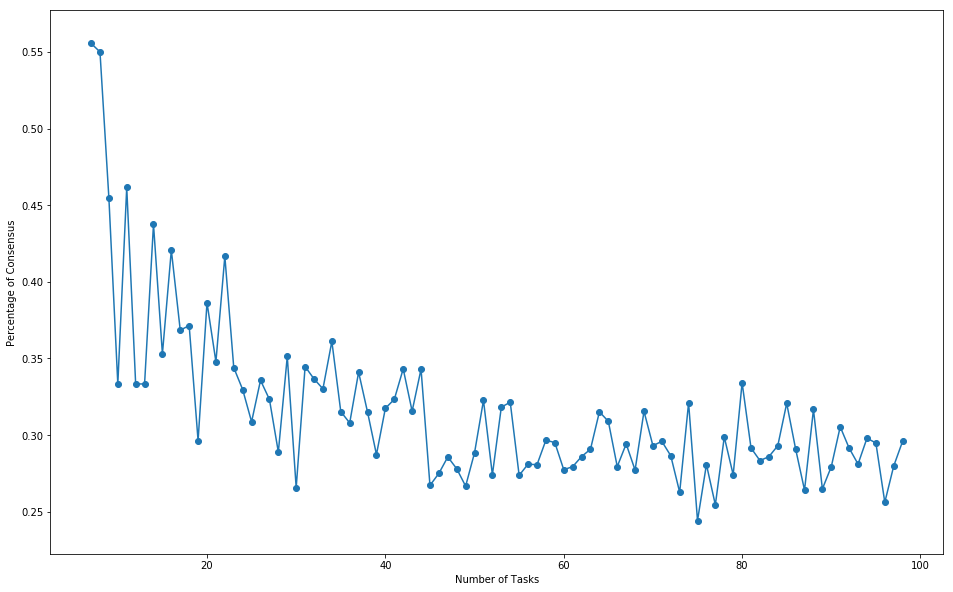

In [27]:
plt.figure(figsize=[16, 10])
plt.scatter(accu.index, accu['accuracy'])
plt.plot(accu.index, accu['accuracy'])
plt.xlabel('Number of Tasks')
plt.ylabel('Percentage of Consensus')
plt.savefig('100tasks10iter.png')

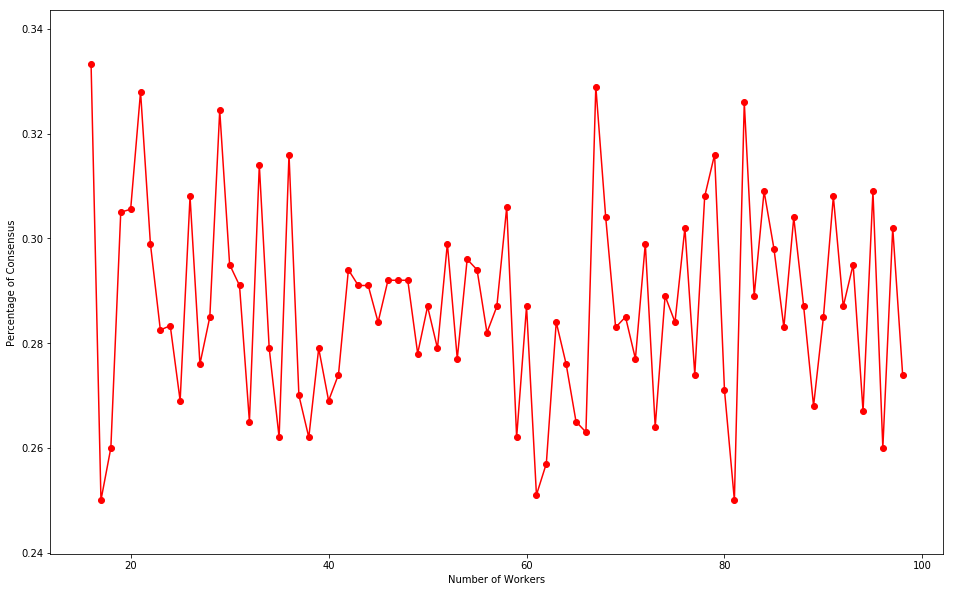

In [40]:
plt.figure(figsize=[16, 10])
plt.scatter(accu.index, accu['accuracy'], color='red')
plt.plot(accu.index, accu['accuracy'], color='red')
plt.xlabel('Number of Workers')
plt.ylabel('Percentage of Consensus')
plt.savefig('100workers10iter.png')

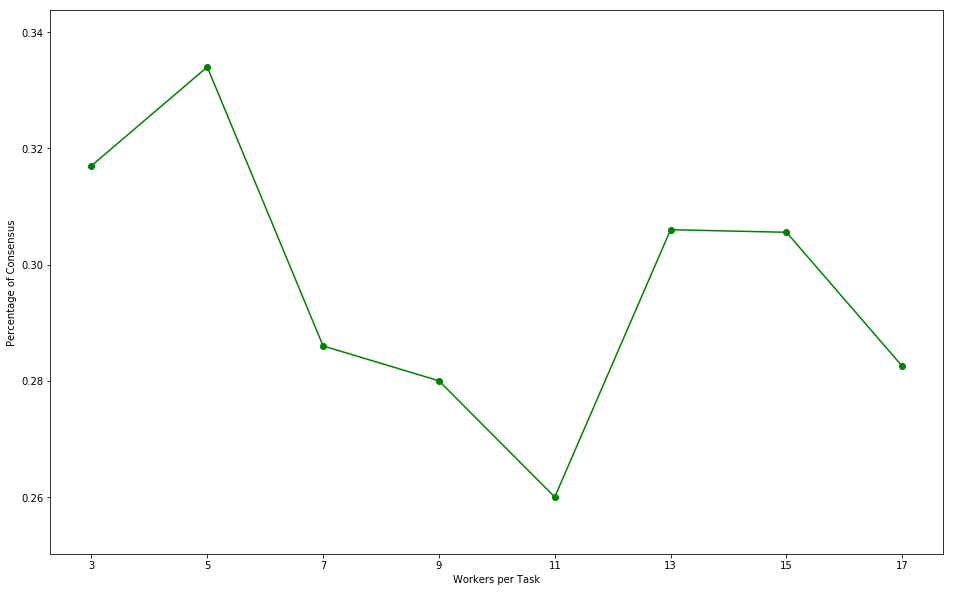

In [56]:
plt.figure(figsize=[16, 10])
plt.scatter(accu.index, accu['accuracy'], color='g')
plt.plot(accu.index, accu['accuracy'], color='g')
plt.xticks(range(len(accu.index)), np.arange(3, 99, 2))
plt.xlabel('Workers per Task')
plt.ylabel('Percentage of Consensus')
plt.savefig('21wpt10iter.png')

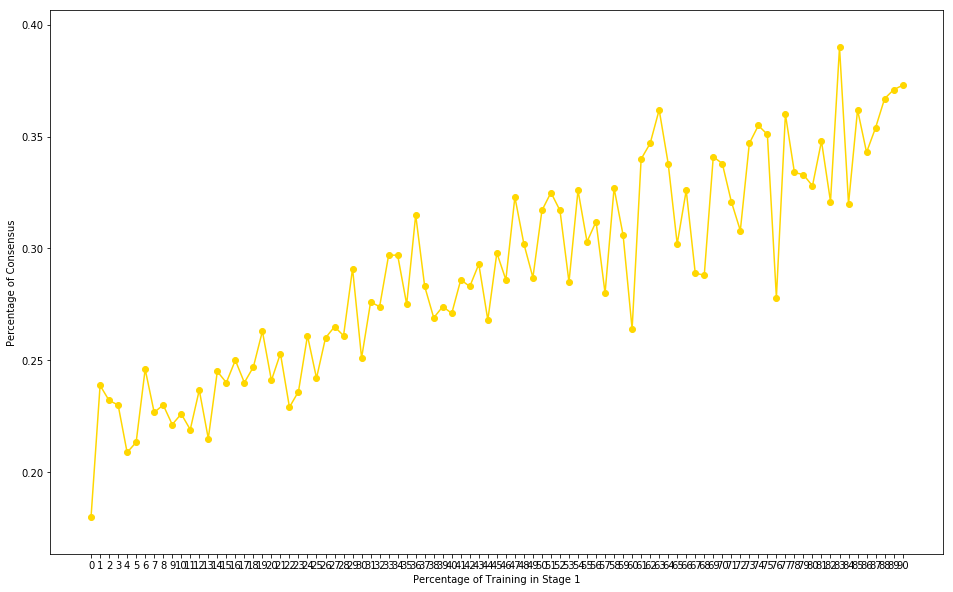

In [90]:
plt.figure(figsize=[16, 10])
plt.scatter(accu.index, accu['accuracy'], color='gold')
plt.plot(accu.index, accu['accuracy'], color='gold')
plt.xticks(range(len(accu.index)), np.arange(0, 100, 1))
plt.xlabel('Percentage of Training in Stage 1')
plt.ylabel('Percentage of Consensus')
plt.savefig('100ptrain10iter.png')